# MILESTONE 1 PHASE 2
`Kevin Boy Gunawan`
<br>

`FTDS-009`

## 1. Introduction

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

link for dataset : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

**Objective**

Objective that i want to achieve from this project is predicting customer churn using deep learn

app url : https://milestone1-p2-kevin-boy.herokuapp.com/

## 2. Import Libraries

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

import pickle
import warnings
warnings.filterwarnings("ignore")

## 3. Data Loading

In [3]:
data = pd.read_csv('/content/drive/MyDrive/churn.csv')

In [4]:
pd.set_option("display.max_columns", 50)

In [5]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [142]:
data.shape

(7043, 21)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


mostly we have columns with object type. but if we looks further, column TotalCharges is supposed to have float type instead of object. so i will make a type-change for this columns and convert it to the numeric type.

In [7]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan, regex=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [8]:
data.isnull().sum().sort_values(ascending=False)

TotalCharges        11
customerID           0
DeviceProtection     0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
OnlineBackup         0
gender               0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
SeniorCitizen        0
Churn                0
dtype: int64

suprisingly there is only few missing value on our datas, its a good sign since we dont need extra effort for handling this missingness

In [9]:
data.duplicated().sum()

0

In [10]:
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

as we can see above, the majority of data is categorical with 2 or 3 clasess

In [11]:
data[['tenure', 'MonthlyCharges', 'TotalCharges']].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


## 4. Exploratory Data Analysis (EDA)

In [12]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


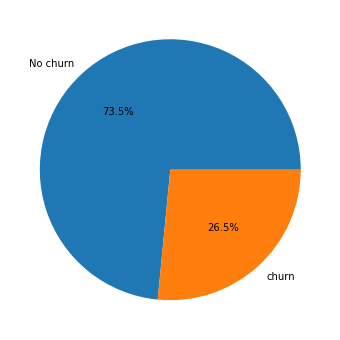

In [13]:
data.Churn.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                               labels=['No churn','churn'], figsize=(9,6),
                               ylabel='')

as we can see above, more than 26% customers are decide to leave. thats quite huge amount and we need to take it seriously. for a better result maybe i will do data sampling later on to overcome class imbalance 

### a. Customer Personal Related EDA

In [14]:
def bar_plt(x):
  fig, axes = plt.subplots(1,2, figsize=(14,5))
  data.groupby(x)['Churn'].value_counts().unstack().plot(kind='bar', ax=axes[0])
  axes[0].set_ylabel('Count');
  axes[0].set_title('Churn Counts by ' + x);
  group = data.groupby(x)['Churn'].value_counts().unstack()
  axes[1].bar([str(group.index[0]), str(group.index[1])], 
          [group.iloc[0][1]/(group.iloc[0][1]+group.iloc[0][0]), group.iloc[1][1]/(group.iloc[1][1]+group.iloc[1][0])],
          width=0.5)
  axes[1].set_ylabel('Ratio');
  axes[1].set_title('Churn Ratio by ' + x);
  axes[1].set_xlim(-0.5, 1.5);

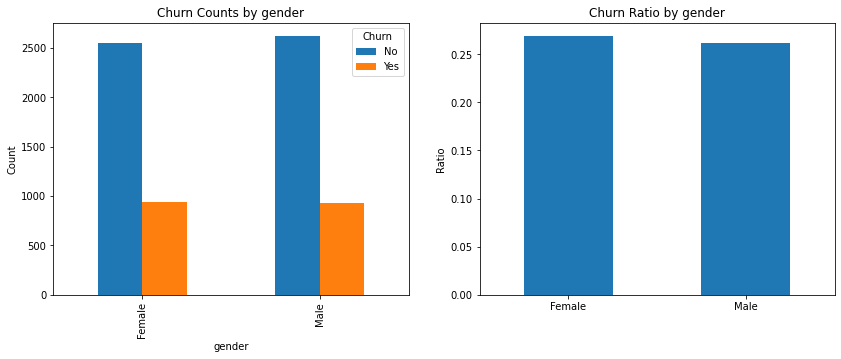

In [15]:
bar_plt('gender')

from the first bar chart abover we can say that the amount of female and male customer are quite balance. and about the churn ratio for each gender its quite balance as well. so we can say that gender is not a big deal to inspect customer churn since both have the same ratio in term of churn

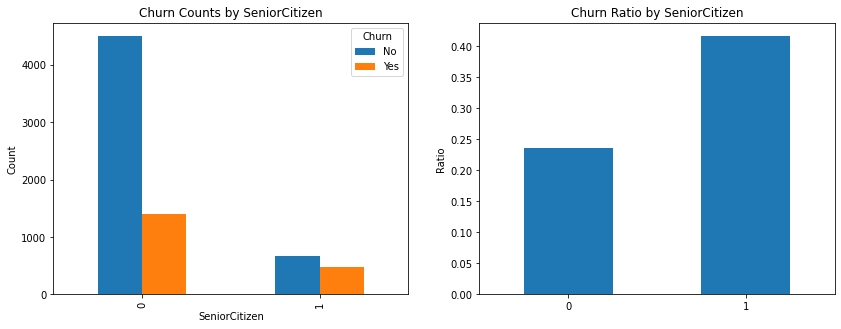

In [16]:
bar_plt('SeniorCitizen')

from the first bar chart above in term of amount, non senior citizen is lead all the way. but sadly this kind of customer are having a big tendency to churn or leave rather than the senior one. its mean that the junior customer is less loyal than the senior one infact that junior customer is the main role customer.

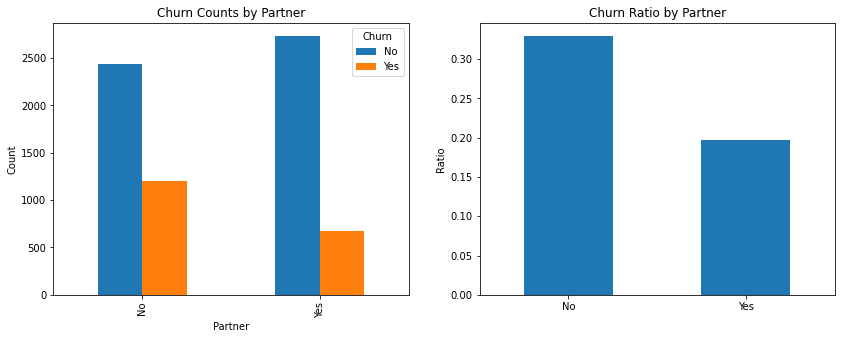

In [17]:
bar_plt('Partner')

a non-partnered customer having a big tendency to churn rather than a partnered one.

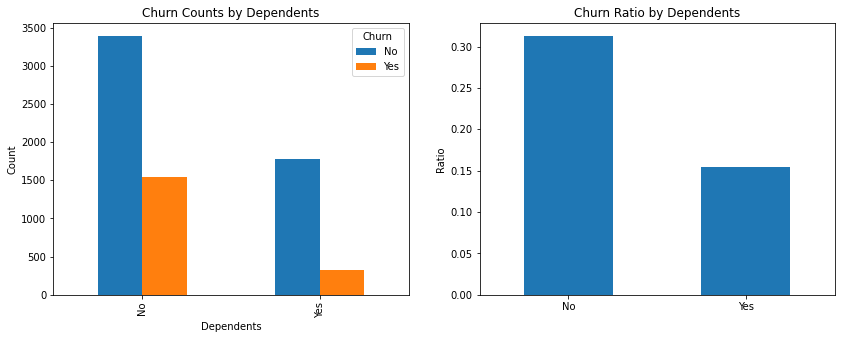

In [18]:
bar_plt('Dependents')

### b. Customer Behaviour Related EDA

In [19]:
def bar_plt(x):
  fig, axes = plt.subplots(1,2, figsize=(14,5))
  data.groupby(x)['Churn'].value_counts().unstack().plot(kind='bar', ax=axes[0])
  axes[0].set_ylabel('Count');
  axes[0].set_title('Churn Counts by ' + x);
  group = data.groupby(x)['Churn'].value_counts().unstack()
  axes[1].bar([str(group.index[0]), str(group.index[1]), str(group.index[2])], 
          [group.iloc[0][1]/(group.iloc[0][1]+group.iloc[0][0]), group.iloc[1][1]/(group.iloc[1][1]+group.iloc[1][0]), group.iloc[2][1]/(group.iloc[2][1]+group.iloc[2][0])],
          width=0.5)
  axes[1].set_ylabel('Ratio');
  axes[1].set_title('Churn Ratio by ' + x);
  axes[1].set_xlim(-0.5, 2.5);

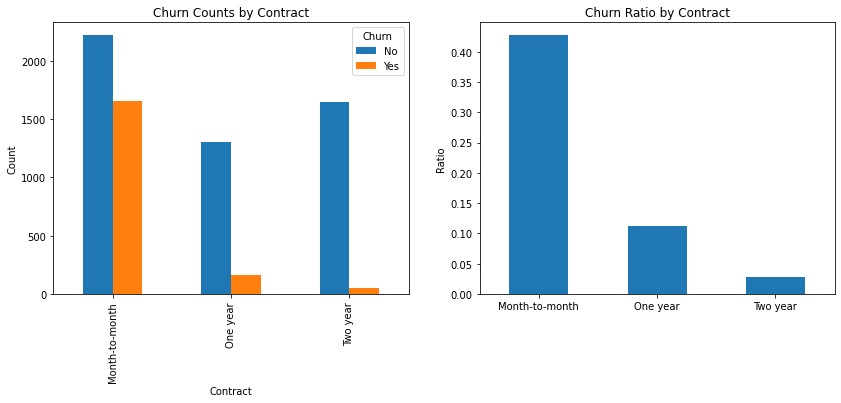

In [20]:
bar_plt('Contract')

based on customer contract there is a crucial information that can be found here. lets have a look on both chart! as we can see, month-to-month contract has a really big churn ratio compare to others contract. if we can see the pattern, the churn ratio is getting decreassed on longer contract. thats mean the longer the contract is, the more loyal the customer are.

Text(0.5, 0, 'Churn Ratio')

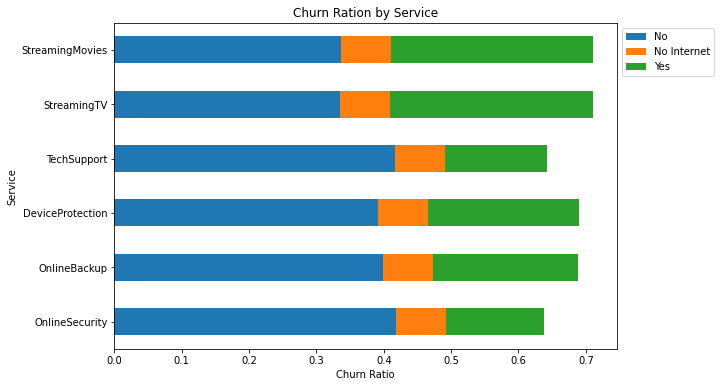

In [21]:
serv = data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']]
ratio1 = []
ratio2 = []
ratio3 = []
for i in serv:
  group = data.groupby(i)['Churn'].value_counts().unstack()
  a = group.iloc[0][1]/(group.iloc[0][1]+group.iloc[0][0])
  b = group.iloc[1][1]/(group.iloc[1][1]+group.iloc[1][0])
  c = group.iloc[2][1]/(group.iloc[2][1]+group.iloc[2][0])
  ratio1.append(a), ratio2.append(b), ratio3.append(c)
ratio = pd.DataFrame({'Service': list(serv.columns), 'No': ratio1, 'No Internet': ratio2, 'Yes': ratio3})
ratio.plot(x = 'Service', kind = 'barh', stacked = True, title = 'Churn Ration by Service', 
           mark_right = True, figsize=(9,6))
plt.legend(bbox_to_anchor =(1, 1))
plt.xlabel('Churn Ratio')

the bar chart above show the customer churn ratio based on several services. lets dig in further on extreme case with contrast ratio. for the example, on online security service there is a huge contrast of churn ratio between the customer who subscribe and not. the customer who doesnt subscribe to online security service are tends to leave rather than the customer who subscribe the service. the same thing happen on tech support as well, there is a high contrast between the custome who subscribe or doesnt subscribe.

we've already had enough with categorical datas, so lets move to evalutate numerical data. here, im using heatmap to check the corelation between the features.

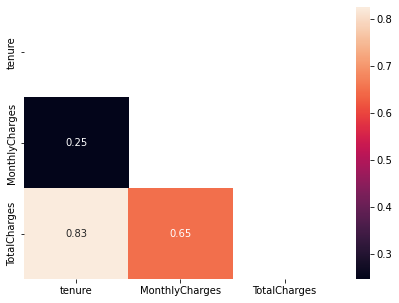

In [22]:
plt.figure(figsize=(7,5))
sns.heatmap(data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), 
            annot=True, mask=np.triu(np.ones_like(data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr())));

from the heatmap matrix above, there are some feature that having a high corelation to other feature.
* total charges has a high corelation to tenure
* total charges has a quite high corelastion with monthly charges as well.

though some features has strong corelation to others, but for this case i might not drop any of them since we lack of numerical data

## 5. Data Preprocessing

before we get further into preprocessing, lets drop some irelavant column that has nothing to do with target. 

In [23]:
data_new = data.drop(columns='customerID')

convert churn or target into numerical binary

In [24]:
data_new['Churn'] = np.where(data_new['Churn']=='Yes', 1, 0)

convert any binary feature to numerical binary

In [25]:
yes_no = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
for i in yes_no:
  data_new[i] = np.where(data_new[i]=='Yes', 1, 0)

In [26]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']
cat_cols = ['gender', 'PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

### a. Data Cleaning

**Outliers Checking**

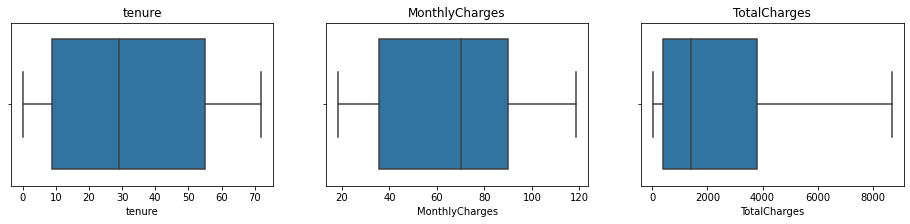

In [27]:
fig, axe = plt.subplots(1,3, figsize=(16,3))
axes = axe.flatten()
for i,j in enumerate(data_new[['tenure', 'MonthlyCharges', 'TotalCharges']].columns):
  sns.boxplot(data_new[j], ax=axes[i]);
  axes[i].set_title(j)
plt.subplots_adjust(hspace=0.4)
plt.show()

suprisingly its clean! there is no outlier on the numerics coloumns.

**Check Missing Value**

In [28]:
data_new.isnull().sum().sort_values(ascending=False)

TotalCharges        11
gender               0
SeniorCitizen        0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
DeviceProtection     0
OnlineBackup         0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
Churn                0
dtype: int64

there is only few missing values on TotalCharges columns. so removing all rows that contain mising value is perform to handle this kind of missing value.

In [103]:
data_new = data_new.dropna()

### b. Data Spliting

so far our datas are clear and neat, lets split the data into train-test-val before we train them

In [104]:
X = data_new.drop(columns='Churn')
y = data_new['Churn']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

now we ready to make a pipeline. for numerical columns lets scale them with minmax scaler.

for categorical columns we encode them using OneHotEncoder.

in this step there is no imputation perform since our datas are clean and neats.

In [31]:
num_pipeline = make_pipeline(MinMaxScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

data_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_cols),
    ('pipe_cat', cat_pipeline, cat_cols)
])

In [105]:
X_train = data_pipeline.fit_transform(X_train)
#X_test = data_pipeline.transform(X_test)
X_valid = data_pipeline.transform(X_valid)

In [107]:
X_train.shape, X_valid.shape

((4746, 42), (1582, 42))

In [34]:
y_train.value_counts()

0    3498
1    1248
Name: Churn, dtype: int64

our data is a bit imbalance, so lets try handle this using SMOTE

In [35]:
smote = SMOTE(random_state = 42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
y_train_balanced.value_counts()

0    3498
1    3498
Name: Churn, dtype: int64

## 6. Model Definition

in model definition we build up NN models using 2 methods, the sequential API and functional API.

**Sequential (1 hidden layer)**

In [36]:
# Build up a model
def sequential_api(n):
  model = Sequential()
  model.add(Dense(n, activation='relu', input_shape=(42,)))
  model.add(Dense(1, activation='sigmoid'))
  return model

**Functional API (2 hidden layer)**

In [37]:
def functional_api(n,m):
  data_in = Input(shape=(42,))
  hidden_1 = Dense(n, activation='relu')(data_in)
  hidden_2 = Dense(m, activation='relu')(hidden_1)
  out = Dense(1, activation='sigmoid')(hidden_2)
  model = Model(inputs=data_in, outputs=out)
  return model

**compile**

In [38]:
def compile_model():
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

in detail, our NN model has 42 input in total. i define 2 model using 2 methods, the sequential one contain 1 hidden layer and the functional one contain 2 hidden layer. the reason why i did this will be explained on the evaluation section later on.

the optimizer that the writers using is adam optimizer, and since our datas has binary output, so for the loss we used binary crosentropy

## 7. Model Training

In [39]:
model = sequential_api(4)
model = compile_model()

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=256).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).shuffle(buffer_size=256).batch(32)

In [ ]:
history = model.fit(train_dataset, epochs=300, validation_data=valid_dataset)

## 8. Model Evaluation

In [42]:
def evaluation():
  metrics = pd.DataFrame(history.history)
  fig, axes = plt.subplots(1,2, figsize=(15,5))
  metrics[['loss', 'val_loss']].plot(ax=axes[0])
  metrics[['accuracy', 'val_accuracy']].plot(ax=axes[1])

In [43]:
def report(feature, og):
  y_pred = model.predict(feature)
  y_pred = np.where(y_pred > 0.5, 1, 0)
  print(classification_report(og, y_pred))

### a. Base Model

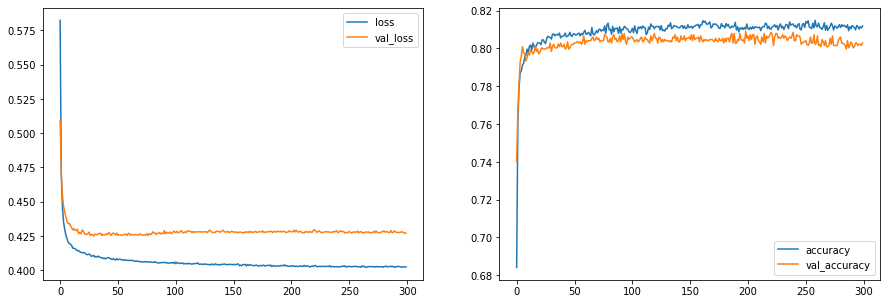

In [44]:
evaluation()

In [45]:
#validation classification report
report(X_valid, y_valid)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1154
           1       0.65      0.57      0.61       428

    accuracy                           0.80      1582
   macro avg       0.75      0.73      0.74      1582
weighted avg       0.80      0.80      0.80      1582



In [46]:
#train classification report
report(X_train, y_train)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      3498
           1       0.66      0.60      0.63      1248

    accuracy                           0.81      4746
   macro avg       0.76      0.74      0.75      4746
weighted avg       0.81      0.81      0.81      4746



for the first attempt our model is not a disappointment. the accuracy is just good, but wait... the recall is a bad news. on this churn case recall score is very crucial because we need to detect this class acuratelly so we can proposed a strategy to minimize them. can our model do better? lets try doing some modiffication!

### b. Some Modification

does adding nodes to the hidden layer make any differences? lets try adding more nodes to the hidden layers, lets say 16 nodes

In [ ]:
model = sequential_api(16)
model = compile_model()
history = model.fit(train_dataset, epochs=100, validation_data=valid_dataset);

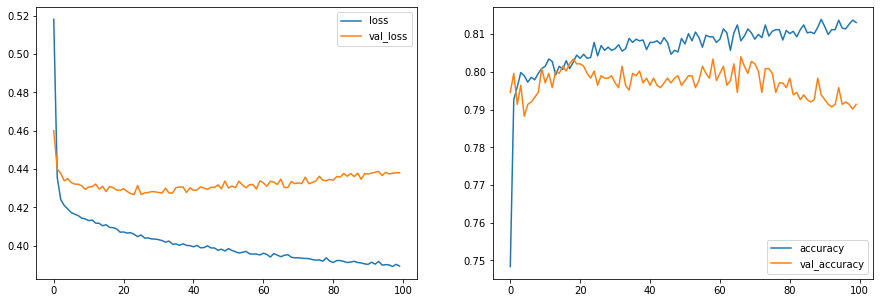

In [48]:
evaluation()

oops, no. its a big no no. the model is overfitting now. adding nodes to the hidden layer for this case is a bad idea, lets try another way.

lets add another layer to our model and now we have a model with 2 hidden layers. lets start with a small nodes, does it work?

In [ ]:
model = functional_api(6,4)
model = compile_model()
history = model.fit(train_dataset, epochs=200, validation_data=valid_dataset);

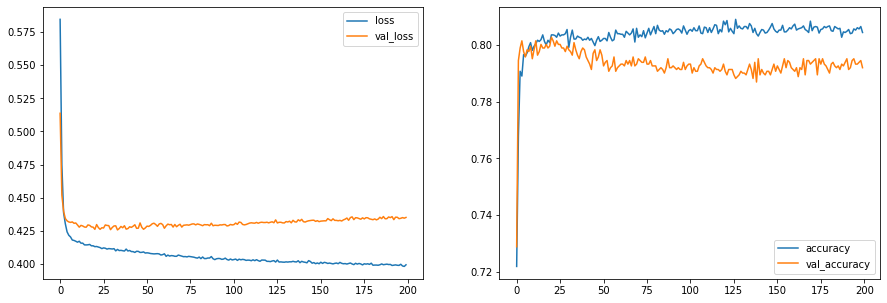

In [50]:
evaluation()

the model still not doing great. okay maybe so far this is what our model can do, the accuracy just stuck at 0.8. just like expert say, NN model is not the best choice and too powerfull for a small data.

### c. Recall optimization


so lets just stick on the very first model, thats the best model so far. our goal now is how to increasng the recall score. so lets train our model using a train set that we've already do a class balancing using SMOTE

In [85]:
model = sequential_api(4)
model = compile_model()

In [ ]:
train_dataset_balanced = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced)).shuffle(buffer_size=1024).batch(128)
history = model.fit(train_dataset_balanced, epochs=600, validation_data=valid_dataset)

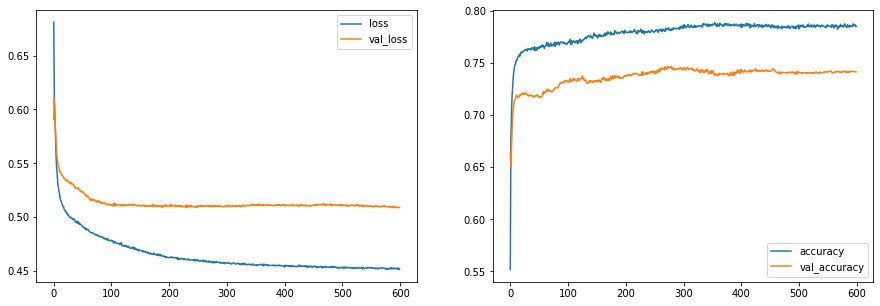

In [87]:
evaluation()

i think the best epoch for this model is around 300 epochs, lets adjust it and evaluate it later on.

In [91]:
model = sequential_api(4)
model = compile_model()

In [ ]:
train_dataset_balanced = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced)).shuffle(buffer_size=1024).batch(128)
history = model.fit(train_dataset_balanced, epochs=300, validation_data=valid_dataset)

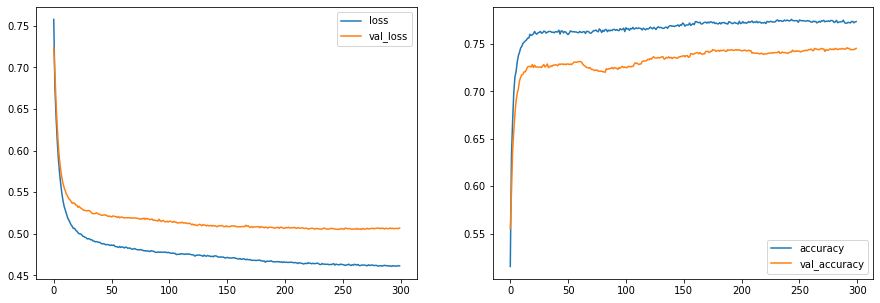

In [93]:
evaluation()

i think the model is kind of underfit, but its not that bad actually so lets just evaluate them.

In [94]:
#validation classification report
report(X_valid, y_valid)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1154
           1       0.52      0.75      0.62       428

    accuracy                           0.75      1582
   macro avg       0.71      0.75      0.71      1582
weighted avg       0.79      0.75      0.76      1582



In [95]:
#train classification report
report(X_train_balanced, y_train_balanced)

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      3498
           1       0.76      0.81      0.79      3498

    accuracy                           0.78      6996
   macro avg       0.78      0.78      0.78      6996
weighted avg       0.78      0.78      0.78      6996



firstly, lets just take a look on the accuaracy. it seems like the accuaracy is decreasing a little compare to the last model we have done. but as long as its not overfit i think thats fine.

the good news is, our recall is increasing significanly. from 0.5 now its turned out to 0.75. its mean that our model is getting better for predicting class 1 (people who decide to leave), and thats what we want here.

## 9. Model Saving

so lets save our best model

In [97]:
model.save('model_NN.h5')

In [101]:
with open('prep_pipeline.pkl', 'wb') as f:
    pickle.dump(data_pipeline, f)

## 10. Model Inference

In [109]:
X_test.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2481,Male,0,1,0,61,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Bank transfer (automatic),25.00,1501.75
6784,Female,0,0,0,19,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Bank transfer (automatic),24.70,465.85
6125,Male,0,1,0,13,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,1,Credit card (automatic),102.25,1359.00
3052,Male,0,1,0,37,Yes,Yes,DSL,Yes,No,No,No,No,No,Month-to-month,1,Mailed check,55.05,2030.75
4099,Female,0,0,0,6,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,0,Bank transfer (automatic),29.45,161.45


In [111]:
X_test_scaled = data_pipeline.transform(X_test)

In [114]:
y_pred_inf = model.predict(X_test_scaled)
y_pred_inf = np.where(y_pred_inf > 0.5, 1, 0)
print(classification_report(y_test, y_pred_inf))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81       511
           1       0.53      0.79      0.63       193

    accuracy                           0.75       704
   macro avg       0.72      0.76      0.72       704
weighted avg       0.80      0.75      0.76       704



from the inference data, the report turned out to be good too. the accuracy and recall, both are just good.

## 11. Conclusion

some conclusion that you may find usefull about this work.
* best NN model to generalize this dataset is using NN with 1 hidden layer and 4 nodes involved.
* by using SMOTE to handle imbalance data, the accuracy and recall of model is just good, both have score up to 0,75 which is not bad.
* deep learning is not recommended for this kind of small dataset. for this dataset by using the best model, the maximum accuracy that model can achieve is just solid 0.8, which is just fine.

app url : https://milestone1-p2-kevin-boy.herokuapp.com/